In [6]:
import networkx as nx
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
from random_network import *
from bba import *

In [2]:
G = Random(N=1000, 
               fm=0.5, 
               d=0.01,
               verbose=False)

In [7]:
aG = DPA(N=1000, 
        fm=0.5, 
        d=0.01, 
        plo_M=2.5, 
        plo_m=2.5,
        verbose=False)

In [3]:
G.nodes[503]

{'gender': 1}

In [8]:
aG.nodes[503]

{'m': 1}

In [12]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

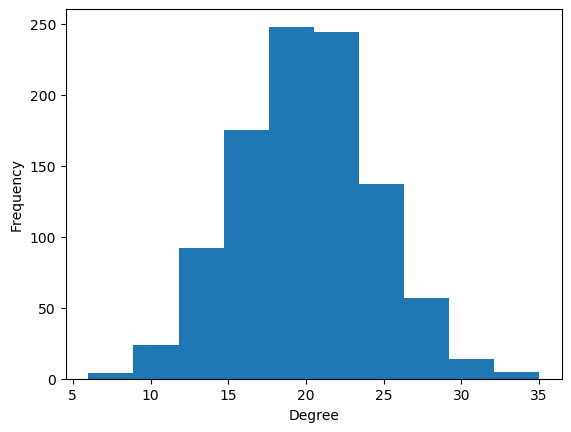

In [14]:
plot_degree_dist(G)

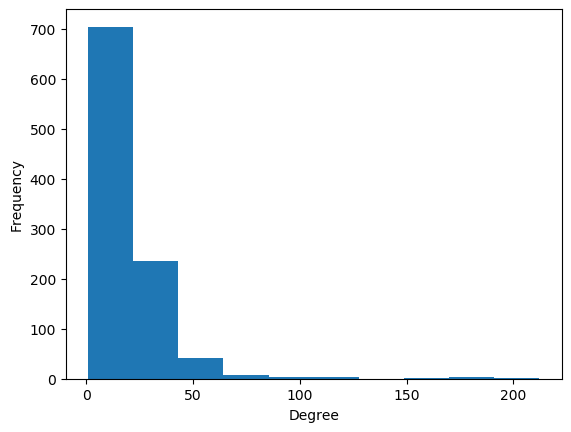

In [13]:
plot_degree_dist(aG)